# Running Version of Tutorial

In [1]:
import pickle
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
%matplotlib inline
warnings.filterwarnings('ignore')

In [3]:
DATA_SET = "data/sample_training_descs.pkl"
RANDOM_SEED = 433

In [4]:
with open(DATA_SET, 'rb') as in_pickle:
    data_df = pickle.load(in_pickle)

data_df.head()

,id,bus_seq_num,target,desc,industry_group_id,construction_flag
0,1000,1.0,0913,livestock operations,01,0
1,10000,1.0,9082,restaurant,36,0
2,1000004,1.0,5537,northern colorado air inc. and northern colora...,27,1
3,1000008,1.0,9083,fast-food chain serving chicken wings and fing...,36,0
4,1000009,1.0,9082,quay's restaurant group llc dba darcy's bistro...,36,0


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
id                   10000 non-null object
bus_seq_num          10000 non-null float64
target               10000 non-null object
desc                 10000 non-null object
industry_group_id    10000 non-null object
construction_flag    10000 non-null object
dtypes: float64(1), object(5)
memory usage: 468.8+ KB


In [6]:
max_characters = 500
print(f"Descriptions - first {max_characters} characters\n")
for _, row in data_df.iloc[:5].iterrows():
    print(f"TARGET: {row['target']} or {row['construction_flag']}\nDESCR: {row['desc'].strip()[:max_characters]}\n")

Descriptions - first 500 characters

TARGET: 0913 or 0
DESCR: livestock operations

TARGET: 9082 or 0
DESCR: restaurant

TARGET: 5537 or 1
DESCR: northern colorado air inc. and northern colorado air of longmont inc. is a hvac contractor in norther colorado.  insured has two locations:  fort collins and sales office in longmont.   insured offers installation, repairs of hvac systems, preventative planned maintenance, and sheet metal fabrication.  insured does residential and light commercial.   

employees will do service calls, replacements, new construction (1111); administrative employees who handle calls, general manager, administrativ

TARGET: 9083 or 0
DESCR: fast-food chain serving chicken wings and fingers, plus burgers, chili and sides

TARGET: 9082 or 0
DESCR: quay's restaurant group llc dba darcy's bistro and pub is a sit down restaurant serving appetizers, alcohol and food.  

full service restaurant.  duties include:  food preparation, order taking, food running, dishwashin

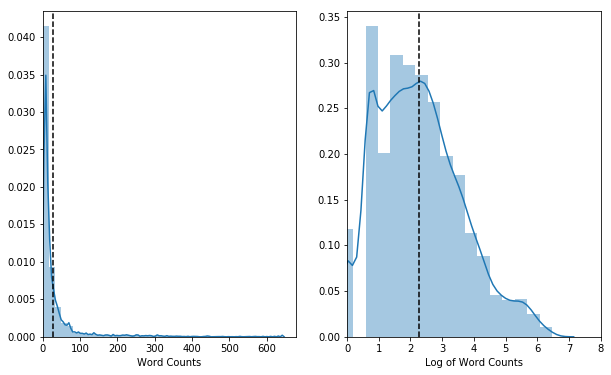

In [7]:
# Graph of log counts and total counts for all descritpions
fig, ax = plt.subplots(1, 2, figsize=(10,6))                            # Make an empty figure we can control
word_counts = data_df['desc'].apply(lambda x: len(x.split()))           # Number of words in each description
log_counts = np.log(word_counts + 0.0001)                               # need small adjustments for any 0's

# Generate first subplot - total counts
sns.distplot(a=word_counts, bins=40, axlabel="Word Counts", ax=ax[0])
ax[0].axvline(x=np.average(word_counts), color='k', linestyle='--')

# Generate second subplot - log counts
sns.distplot(a=log_counts, bins=40, axlabel="Log of Word Counts", ax=ax[1])
ax[1].axvline(x=np.average(log_counts), color='k', linestyle='--')

# Clean these up a bit
ax[0].set_xlim(left=0)
ax[1].set_xlim(left=0);

In [8]:
# See numbr of words (not perfect still has punctuation and stuff)
num_words = len(set(' '.join(data_df['desc']).split(' ')))
print(f"Total Non-Uqique Words {num_words:,}")

# Make a big string of all the descriptions
pass

# Make a list of all the words
pass

# Remove punctuation from all words
pass

# Get a count of all the unique words
from collections import Counter        # just an option to use, many other options
pass

# Examine counts, maybe plot like above if wanted
pass

Total Non-Uqique Words 25,438


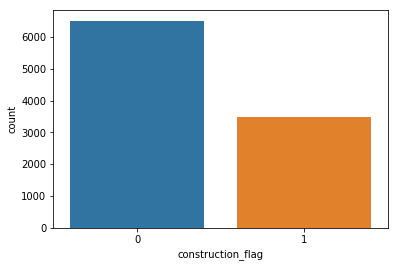

In [9]:
fig, ax = plt.subplots()
sns.countplot(data=data_df, x='construction_flag', ax=ax);

In [10]:
def summarize_doc_transformation(doc_df, doc_index, trained_vectorizer, tfidf_matrix, column='desc',
                                 terms_per_line=4):
    """
    DESCR: A function to help evaluate the individual transformation of documents to tfidf vectors.
    INPUT: doc_df - pandas.DataFrame - 
           doc_index - int - 
           trained_vectorizer - sklearn...tfidfVec... -  
    OUTPUT: stdout, no return
    """
    # Print out what this document looked like before transformation
    print(f"DOCUMENT: {doc_index}")
    print("ORIGINAL DOCUMENT:")
    print(f"{repr(doc_df.iloc[doc_index][column])}\n")
    
    # See a tfidf represenation
    vect = tfidf_matrix.todense()[doc_index,:]    # get a single vector to work with
    
    # take only the non-zero terms
    important_terms = [(term, vect[0, index]) for term, index in trained_vectorizer.vocabulary_.items()
                       if vect[0, index] != 0]
    
    # Sort by most to least important
    important_terms = sorted(important_terms, key=lambda x: x[1], reverse=True)

    # print out the terms along with their tfidfs
    print("NON ZERO VECTOR VALUES (Most to Least Important):")
    words_on_line = 0
    for term, tfidf in important_terms:
        print(f"{term+':':<15} {tfidf:0.3f}    ", end="")
        words_on_line += 1
        if words_on_line >= terms_per_line:
            print()
            words_on_line = 0
    
    print(f"\nTERMS w/ ZERO VALUE: {tfidf_matrix.shape[1] - len(important_terms):,}")
    print(f"Sum of terms: {sum([tfidf for term, tfidf in important_terms]):0.2f}")

In [11]:
# Import and set up and object to transform our text
# leaving this all very conservative, can be tweeked and experimented with
# all of these hyper paramters could alternatively be found via a cross validated gridsearch
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(strip_accents='ascii',    # don't need é kind of stuff
                             ngram_range=(1,1),        # could have 'dog runner' as a single term if 2
                             stop_words='english',     # a, the, is, or, ....
                             max_df=0.8,               # is it in too many documnets?  
                             min_df=0.0,               # is it in too few documents?
                             max_features=None,        # try to avoid ridiculously high dimensionality
                             preprocessor=None,        # replace to customize preporcessing
                             tokenizer=None,           # replace to customize token generation
                             )

In [12]:
data_df.head()

,id,bus_seq_num,target,desc,industry_group_id,construction_flag
0,1000,1.0,0913,livestock operations,01,0
1,10000,1.0,9082,restaurant,36,0
2,1000004,1.0,5537,northern colorado air inc. and northern colora...,27,1
3,1000008,1.0,9083,fast-food chain serving chicken wings and fing...,36,0
4,1000009,1.0,9082,quay's restaurant group llc dba darcy's bistro...,36,0


In [14]:
tfidf_matrix = vectorizer.fit_transform(data_df['desc'])

# Explain some thing about this object
print(f"Data structure: {type(tfidf_matrix)}")
print(f"Number of rows (documents): {tfidf_matrix.shape[0]:,}")
print(f"Number of features (terms): {tfidf_matrix.shape[1]:,}")

Data structure: <class 'scipy.sparse.csr.csr_matrix'>
Number of rows (documents): 10,000
Number of features (terms): 12,054


In [20]:
doc_ind = 17
summarize_doc_transformation(data_df, doc_ind, vectorizer, tfidf_matrix)

DOCUMENT: 17
ORIGINAL DOCUMENT:
'aaa service plumbing provides plumbing, hvac and electrical service to residential customers in the denver metro area. all work is on existing houses, no new construction. operates from one location on marshall street. service is offered 1 days per week. technicians specialize in plumbing which includes repair or replacement of pipes and fixtures, drain cleaning or sewer repair; electrical which includes the repair and replacement of wiring and electrical fixtures; or hvac which involves the repair or replacement of forced air heating and air conditioning systems. warehouse staff and fleet manager work for all the services in the warehouse area where supplies are stored and vehicles are managed. the service manager works in the office providing technical advice to the technicians via phone. he may visit a job site and may assist with repairs. works for with all service technicians. there is a large office staff that includes accounting who maintain the 

In [21]:
# Import a bunch of stuff to create a model
from sklearn.tree import DecisionTreeClassifier as TreeModel
from sklearn.model_selection import train_test_split
from graphviz import Source
from IPython.display import SVG
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score

# If on windows like me will need to add in location to graphviz
# You will need to alter the path accordingly, maybe just your username will change
#import os
#os.environ['PATH'] += ';C:\\Users\\ranneyr\\AppData\\Local\\Continuum\\Anaconda3\\envs\\pendragon\\Library\\bin\\graphviz'

In [22]:
# We need a hold out set
# we will use this to evaluate a final model
X_train, X_test, y_train, y_test = train_test_split(tfidf_matrix, data_df['construction_flag'])

In [23]:
# Have to remap features names from the vectorizer object
# kind of a hassle, but makes tree much more interpretable
features = [term for num, term in sorted([(num, term) 
            for term, num in vectorizer.vocabulary_.items()])]

In [25]:
clf = TreeModel(max_depth=1, criterion='entropy').fit(X_train, y_train)

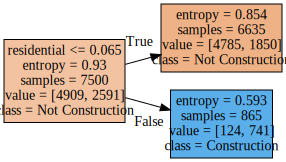

In [26]:
graph = Source(export_graphviz(clf, out_file=None, feature_names=features, filled=True, rotate=True,
                               class_names=['Not Construction', 'Construction']))
SVG(graph.pipe(format='svg'))

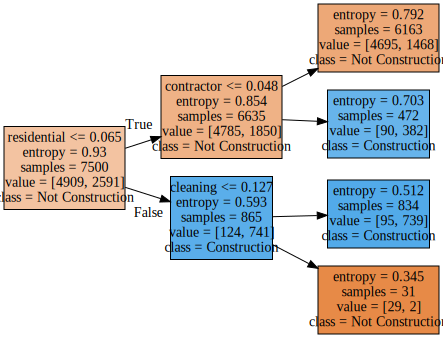

In [28]:
# Go deeper to a nother split
clf = TreeModel(max_depth=2, criterion='entropy').fit(X_train, y_train)
graph = Source(export_graphviz(clf, out_file=None, feature_names=features, filled=True, rotate=True,
                               class_names=['Not Construction', 'Construction']))
SVG(graph.pipe(format='svg'))

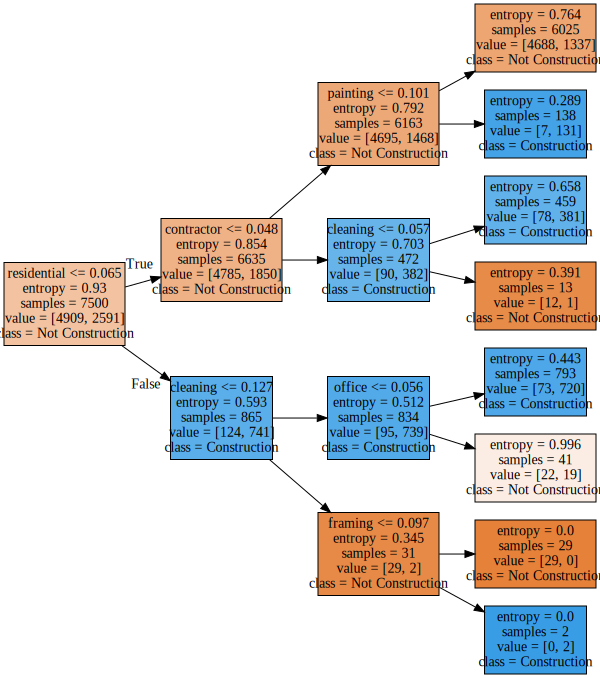

In [29]:
# Now going to a third split, this is getting a bit large
clf = TreeModel(max_depth=3, criterion='entropy').fit(X_train, y_train)
graph = Source(export_graphviz(clf, out_file=None, feature_names=features, filled=True, rotate=True,
                               class_names=['Not Construction', 'Construction']))
SVG(graph.pipe(format='svg'))

In [30]:
# No depth restrictions on this tree
clf = TreeModel(criterion='entropy').fit(X_train, y_train)

In [31]:
from sklearn.metrics import accuracy_score
train_predictions = clf.predict(X_train)
acc_train = accuracy_score(y_train, train_predictions)
print(f"Training Data Accuracy: {acc_train*100:0.2f}%")

Training Data Accuracy: 99.21%


In [32]:
untrained_predictions = clf.predict(X_test)
acc_test = accuracy_score(y_test, untrained_predictions)
print(f"Testing Data Accuracy: {acc_test*100:0.2f}%")

Testing Data Accuracy: 89.24%


In [33]:
# Use a nice plot found online - sklearn documentation has lots of this stuff
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    """
    Taken From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-
               model-selection-plot-confusion-matrix-py    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

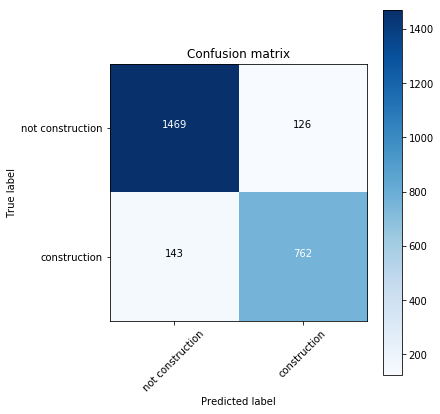

In [34]:
# Plot out resultant confusion matrix
cm = confusion_matrix(y_test, untrained_predictions)
fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(cm, ['not construction', 'construction'])

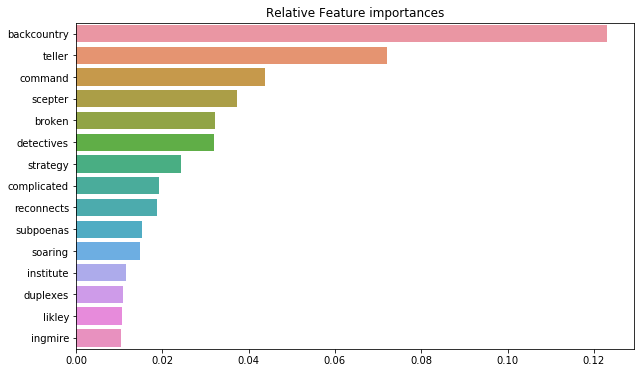

In [35]:
term_importances = list(zip(clf.feature_importances_, vectorizer.vocabulary_))
term_importances = sorted(term_importances, reverse=True)
plt.subplots(figsize=(10, 6))
plt.title("Relative Feature importances")
sns.barplot(y=[x[1] for x in term_importances[:15]], 
            x=[x[0] for x in term_importances[:15]],
            orient='h');

In [36]:
max_depth = clf.tree_.max_depth
print(f"Max depth of tree: {max_depth} branches")

Max depth of tree: 465 branches


In [37]:
# Make final model, note we only played with one of many tunable hyperparameters
final_clf = TreeModel(max_depth=152).fit(X_train, y_train)

In [39]:
desc = "I am a dancing clown who performs at residential and commercial parties"

my_business = pd.DataFrame([desc], columns=["desc"])
encoded = vectorizer.transform(my_business['desc'])
summarize_doc_transformation(my_business, 0, vectorizer, encoded)

# See the Final output
not_construction, construction = final_clf.predict_proba(encoded)[0]
print(f"\nThere is a {construction * 100: 0.2f}% chance you are construction")

DOCUMENT: 0
ORIGINAL DOCUMENT:
'I am a dancing clown who performs at residential and commercial parties'

NON ZERO VECTOR VALUES (Most to Least Important):
dancing:        0.595    parties:        0.575    performs:       0.454    commercial:     0.251    
residential:    0.213    
TERMS w/ ZERO VALUE: 12,049
Sum of terms: 2.09

There is a  100.00% chance you are construction


In [51]:
# load in the testing data
test_data_location = 'data/test_df.pkl'
with open(test_data_location, 'rb') as in_pickle:
    test_df = pickle.load(in_pickle)

In [52]:
test_df.head()

,id,bus_seq_num,target,desc,industry_group_id
0,1000,1.0,0913,livestock operations,01
1,10000,1.0,9082,restaurant,36
2,1000004,1.0,5537,northern colorado air inc. and northern colora...,27
3,1000008,1.0,9083,fast-food chain serving chicken wings and fing...,36
4,1000009,1.0,9082,quay's restaurant group llc dba darcy's bistro...,36


In [55]:
final = test_df['id'].to_frame()

encoded = vectorizer.transform(test_df['desc'])
final['pred_class'] = final_clf.predict(encoded)


In [58]:
final.to_csv('data/kaggle_submission.csv', index=False)

In [59]:
! head -n 10 data/kaggle_submission.csv

id,pred_class
1000,0
10000,0
1000004,0
1000008,0
1000009,0
100001,0
1000010,0
1000012,1
1000018,0
